# Segmentación de cerebro

## Imports

### Instalación de librerías

In [1]:
!pip install monai nibabel torch torchvision

### Llamado de librerías

In [5]:
import monai
print(monai.__version__)

1.5.0


In [7]:
import os
import glob
import torch
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ToTensord, RandFlipd, RandRotate90d
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

Nota:
AddChanneld -> EnsureChannelFirstd
Fuente: https://github.com/Project-MONAI/MONAI/discussions/8147


## Lectura de los datos

In [22]:
data_dir_t1 = 'datosparaentrenar/T1-freesurfer'
data_dir_seg = 'datosparaentrenar/aparc-aseg'
t1_paths = sorted(glob.glob(os.path.join(data_dir_t1, '*.nii.gz')))
seg_paths = sorted(glob.glob(os.path.join(data_dir_seg, '*.nii.gz')))

# Crear lista de diccionarios para MONAI
data_dicts = [{'image': img, 'label': seg} for img, seg in zip(t1_paths, seg_paths)]

#### Verifico que se hayan leido bien los datos


In [23]:
print(f"Número de estudios: {len(data_dicts)}")
print("Primer ejemplo:")
print(data_dicts[0])

Número de estudios: 10
Primer ejemplo:
{'image': 'datosparaentrenar/T1-freesurfer\\1301-T1.nii.gz', 'label': 'datosparaentrenar/aparc-aseg\\1301-aparcaseg-label.nii.gz'}


## Preparación de los dataset

In [32]:
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    ScaleIntensityd(keys=['image']),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=['image', 'label'], prob=0.5, spatial_axes=(0, 1)),
    ToTensord(keys=['image', 'label'])
])


#train_ds = Dataset(data=data_dicts, transform=train_transforms)
#train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

In [33]:
from sklearn.model_selection import train_test_split

# 80% entrenamiento, 20% test
train_files, test_files = train_test_split(data_dicts, test_size=0.2, random_state=42)

train_ds = Dataset(data=train_files, transform=train_transforms)
test_ds = Dataset(data=test_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1)

print(f"N° entrenamiento: {len(train_ds)}, N° test: {len(test_ds)}")


N° entrenamiento: 8, N° test: 2


### Visualización

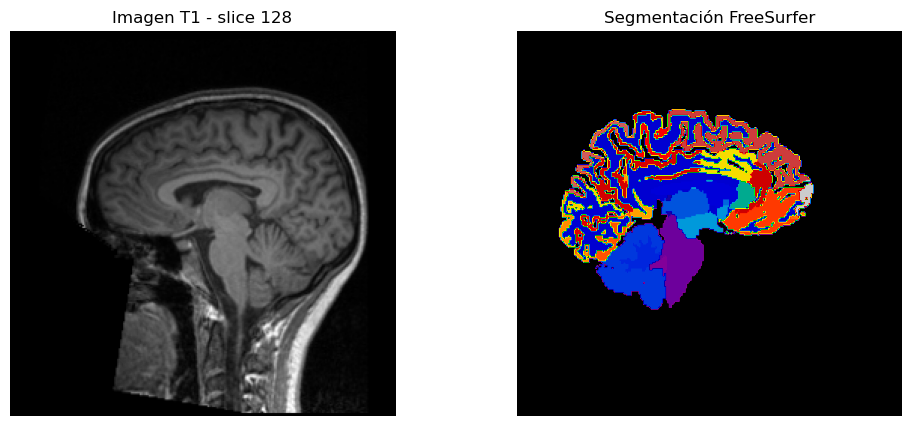

In [37]:
import matplotlib.pyplot as plt

def mostrar_slice(batch_data, slice_index=None):
    image = batch_data["image"][0, 0].cpu().numpy()  # [B, C, D, H, W]
    label = batch_data["label"][0, 0].cpu().numpy()

    if slice_index is None:
        slice_index = image.shape[0] // 2

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image[slice_index], cmap="gray")
    plt.title(f"Imagen T1 - slice {slice_index}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(label[slice_index], cmap="nipy_spectral")
    plt.title("Segmentación FreeSurfer")
    plt.axis("off")

    plt.show()

# 🔍 Usar
batch_data = next(iter(train_loader))
mostrar_slice(batch_data)

#### chequeo

In [26]:
# Tomar la primera muestra y aplicar transformaciones
sample = train_ds[0]

print(f"Tipo de sample: {type(sample)}")
print(f"Keys: {sample.keys()}")

print(f"Shape de imagen: {sample['image'].shape}")
print(f"Shape de etiqueta: {sample['label'].shape}")

print(f"Tipo de dato imagen: {sample['image'].dtype}")
print(f"Tipo de dato etiqueta: {sample['label'].dtype}")

print(f"Shape de imagen y etiqueta deben coincidir: {sample['image'].shape == sample['label'].shape}")

# Opcional: mostrar min y max para comprobar intensidad y etiquetas
print(f"Imagen - min: {sample['image'].min()}, max: {sample['image'].max()}")
print(f"Etiqueta - min: {sample['label'].min()}, max: {sample['label'].max()}")

Tipo de sample: <class 'dict'>
Keys: dict_keys(['image', 'label'])
Shape de imagen: torch.Size([1, 256, 256, 256])
Shape de etiqueta: torch.Size([1, 256, 256, 256])
Tipo de dato imagen: torch.float32
Tipo de dato etiqueta: torch.float32
Shape de imagen y etiqueta deben coincidir: True
Imagen - min: 0.0, max: 1.0
Etiqueta - min: 0.0, max: 109.0


## Configuración, definición del modelo

In [38]:
import numpy as np
import nibabel as nib

# Analizar una segmentación para obtener clases únicas
seg = nib.load(seg_paths[0]).get_fdata()
classes = np.unique(seg)
print(f"Clases únicas encontradas: {classes}")
print(f"Número de clases: {len(classes)}")

Clases únicas encontradas: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.]
Número de clases: 110


In [39]:
# Definir modelo, loss, optimizador y métricas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(classes),  # cuento 109 segmentos + 1 fondo = 110
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


## Entrenamiento

In [28]:
max_epochs = 5
model.train()

for epoch in range(max_epochs):
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss/step:.4f}")

Epoch 1/5, Loss: 0.9980
Epoch 2/5, Loss: 0.9962
Epoch 3/5, Loss: 0.9931
Epoch 4/5, Loss: 0.9883
Epoch 5/5, Loss: 0.9838


## Guardar modelo

In [29]:
torch.save(model.state_dict(), "simple_cnn3d_segmentation.pth")

## Evaluación de modelo

In [ ]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)

        test_outputs = model(test_inputs)
        test_outputs = torch.softmax(test_outputs, 1)
        dice_metric(y_pred=test_outputs, y=test_labels)

    mean_dice = dice_metric.aggregate().item()
    print(f"Dice en test: {mean_dice:.4f}")
    dice_metric.reset()

## Visualización

In [ ]:
import nibabel as nib
import os

def visualizar_prediccion_y_guardar(model, batch_data, output_dir="resultados", nombre_base="pred"):
    os.makedirs(output_dir, exist_ok=True)

    model.eval()
    image = batch_data["image"].to(device)
    label = batch_data["label"][0, 0].cpu().numpy()

    # Predicción
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(torch.softmax(output, dim=1), dim=1)[0].cpu().numpy()

    # Slice para visualizar
    slice_index = label.shape[0] // 2

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, 0, slice_index].cpu(), cmap="gray")
    plt.title("Imagen T1")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label[slice_index], cmap="nipy_spectral")
    plt.title("Segmentación Real")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred[slice_index], cmap="nipy_spectral")
    plt.title("Predicción")
    plt.axis("off")
    plt.show()

    # Guardar como NIfTI
    nifti = nib.Nifti1Image(pred.astype(np.uint8), affine=np.eye(4))
    nib.save(nifti, os.path.join(output_dir, f"{nombre_base}_pred.nii.gz"))
    print(f"Predicción guardada en: {output_dir}/{nombre_base}_pred.nii.gz")

#  Probar con un batch del test set
batch_test = next(iter(test_loader))
visualizar_prediccion_y_guardar(model, batch_test, nombre_base="ejemplo1")